# Global Imports

In [130]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from einops import rearrange
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn
from typing import Any
import glob
import re
from datetime import datetime
import random
from collections import defaultdict
from collections import Counter
random.seed(42)

# Local Imports

In [131]:
from training.train import EpochLogs, grid_search, LogPoint
from dataset.character_dataset import CharImageDataset
from models.allcnn2d import AllCNN2D

# Globals

In [132]:
DATASET_SPLIT: float = 0.8
MODEL_NAME: str = "Krud"
LOAD_CHECKPOINT: str = r"C:\Users\Leon\visual-studio\repos\Le-o-n\ocr-model-training\checkpoints\Jigsaw_epoch12_trainacc0.92045_valacc0.96591_Tloss0.015995_Vloss0.0063332_lr0.0007224.pkl"

# Define Paths
Workspace

In [133]:
notebook_dir: str = os.path.abspath(".")
root_dir: str = os.path.join(
    notebook_dir,
    os.pardir,
    os.pardir
)

data_dir: str = os.path.join(
    root_dir,
    "data",
    "lambda"
)

model_save_dirpath: str = os.path.join(
    root_dir,
    "models",
    "allcnn"
)


Image paths

In [134]:

images_path_glob: str = os.path.join(
    data_dir,
    "u*.png"
)
images_path_regex: str = r"(u[0-9a-f]+)-([0-9]+)\.png"

image_paths: list[str] = glob.glob(images_path_glob)
random.shuffle(image_paths)

len(image_paths)

1104

# Helper Functions

In [135]:
def get_current_time() -> str:
    return datetime.now().strftime("%Y-%m-%d-%H-%M-%S")


# Logging Setup 

In [136]:

logging_path: str = f"{MODEL_NAME}_log_{get_current_time()}.csv"

with open(logging_path, "w") as f:
    f.write("TIME,EPOCH,TRAIN_ACC,VAL_ACC,TRAIN_LOSS,VAL_LOSS,LR\n")

def log(
    epoch: int,
    train_acc: float, 
    train_loss: float, 
    val_acc: float, 
    val_loss, 
    lr: float
)-> None:
    with open(logging_path, "a") as f:
        f.write(f"{get_current_time()},{epoch},{train_acc},{val_acc},{train_loss},{val_loss},{lr}\n")

# Extract Labels From File Names

In [137]:


labeled_image_paths: list[tuple[str, str]] = []

class_counts: dict[str, int] = defaultdict(lambda: 0)

file_path: str
for file_path in image_paths:
    match = re.search(images_path_regex, file_path)
    
    if not match:
        continue
    
    u_hexvalue: str = match.group(1)
    
    class_counts[u_hexvalue] += 1
    
    
    labeled_image_paths.append((u_hexvalue, file_path))

labels: list[str]
image_paths: list[str]
labels, image_paths =  list(zip(*labeled_image_paths))

len(labels), len(image_paths)

(1104, 1104)

In [138]:
Counter(labels)

Counter({'u61': 54,
         'u2b': 54,
         'u31': 54,
         'u3bb': 49,
         'u2e': 49,
         'u28': 48,
         'u29': 48,
         'u2d': 23,
         'uf7': 23,
         'ud7': 22,
         'u6f': 20,
         'u30': 20,
         'u73': 20,
         'u69': 20,
         'u63': 20,
         'u6a': 20,
         'u67': 20,
         'u65': 20,
         'u77': 20,
         'u6c': 20,
         'u6e': 20,
         'u64': 20,
         'u36': 20,
         'u76': 20,
         'u70': 20,
         'u6d': 20,
         'u79': 20,
         'u74': 20,
         'u33': 20,
         'u35': 20,
         'u71': 20,
         'u34': 20,
         'u78': 20,
         'u6b': 20,
         'u68': 20,
         'u38': 20,
         'u32': 20,
         'u75': 20,
         'u39': 20,
         'u72': 20,
         'u7a': 20,
         'u62': 20,
         'u37': 20,
         'u66': 20})

# Balance Classes Using Oversample/Undersample

In [139]:
sorted_counts: list[tuple[str, int]] = sorted(
    class_counts.items(), 
    key=lambda x: x[0]
)

counts: list[int] = [pair[1] for pair in sorted_counts]

max_count: int = max(counts)
min_count: int = min(counts)

to_add_counts: dict[str, int] = {
    uid: max_count - count 
    for uid, count in 
    sorted_counts
}

to_undersample_counts: dict[str, int] = {
    uid: min_count
    for uid, count in 
    sorted_counts
}

total_items = sum(x[1] for x in sorted_counts)


In [140]:
min_count, max_count, total_items

(20, 54, 1104)

In [141]:
#print(*to_add_counts.items())
#print(sorted([(chr(int(pair[0][1:], 16)), pair[1]) for pair in to_remove_counts.items()], key=lambda x: x[1]))

# Oversample

In [142]:
#to_add_labels: list[str] = []
#to_add_file_paths: list[str] = []
#
#while True in [to_add_count>0 for to_add_count in to_add_counts.values()]:  
#    for label, image_path in zip(labels, image_paths):
#        remaining: int = to_add_counts[label]
#        
#        if remaining > 0:
#            to_add_labels.append(label)
#            to_add_file_paths.append(image_path)
#            to_add_counts[label] -= 1

# Undersample

In [143]:
to_keep_labels: list[str] = []
to_keep_file_paths: list[str] = []

while True in [to_add_count>0 for to_add_count in to_undersample_counts.values()]:  
    for label, image_path in zip(labels, image_paths):
        remaining: int = to_undersample_counts[label]
        
        if remaining > 0:
            to_keep_labels.append(label)
            to_keep_file_paths.append(image_path)
            to_undersample_counts[label] -= 1

In [144]:

Counter(to_keep_labels)

Counter({'u3bb': 20,
         'u6f': 20,
         'u30': 20,
         'u73': 20,
         'u61': 20,
         'u69': 20,
         'u63': 20,
         'u6a': 20,
         'u67': 20,
         'u28': 20,
         'u65': 20,
         'ud7': 20,
         'u77': 20,
         'u6c': 20,
         'u6e': 20,
         'u2e': 20,
         'u64': 20,
         'u36': 20,
         'u2d': 20,
         'u76': 20,
         'u70': 20,
         'u6d': 20,
         'u79': 20,
         'u74': 20,
         'u33': 20,
         'u35': 20,
         'u71': 20,
         'u34': 20,
         'u78': 20,
         'u6b': 20,
         'uf7': 20,
         'u68': 20,
         'u38': 20,
         'u2b': 20,
         'u32': 20,
         'u31': 20,
         'u29': 20,
         'u75': 20,
         'u39': 20,
         'u72': 20,
         'u7a': 20,
         'u62': 20,
         'u37': 20,
         'u66': 20})

# Load Dataset

In [145]:
image_paths = to_keep_file_paths
labels = to_keep_labels
len(image_paths), len(labels)

(880, 880)

In [146]:

split_index: int = int(len(image_paths)*DATASET_SPLIT)
all_label_classes: list[str] = sorted(list(set(labels)))

In [147]:

train_char_dataset: CharImageDataset = CharImageDataset(
    file_paths=image_paths[:split_index], #list(image_paths[:split_index]) + to_add_file_paths,
    labels=labels[:split_index], #list(labels[:split_index]) + to_add_labels,
    all_label_classes=all_label_classes,
    rotation_limit=0.05,
    translation_limit=0.2,
    skew_limit=0.02,
    zoom_change=1.2,
    min_zoom=0.8,
    thicken_sigma=-4.9,
    image_dims=(64, 64)
)

val_char_dataset: CharImageDataset = CharImageDataset(
    file_paths=image_paths[split_index:],
    labels=labels[split_index:],
    all_label_classes=all_label_classes,
    rotation_limit=0.0,
    translation_limit=0.0,
    skew_limit=0.00,
    zoom_change=0.0,
    min_zoom=1.0,
    thicken_sigma=0.0,
    image_dims=(64, 64)
)




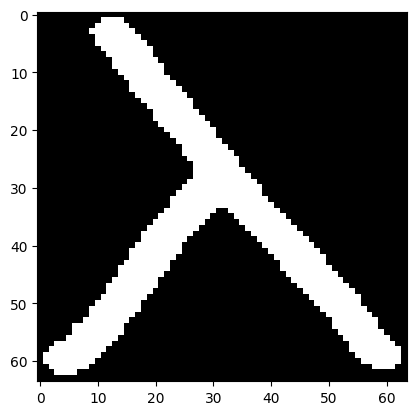

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])


In [148]:
for im, lab in train_char_dataset:
    plt.imshow(
        rearrange(im, "1 h w -> h w")*255, 
        cmap="gray"
    )
    plt.show()
    print(lab)
    break

torch.Size([1, 64, 64])


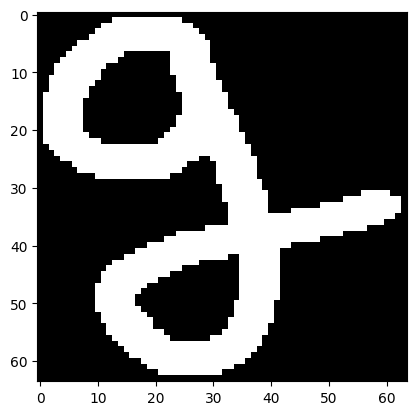

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])


In [149]:
for im, lab in val_char_dataset:
    print(im.shape)
    plt.imshow(rearrange(im, "1 h w -> h w")*255, cmap="gray")
    plt.show()
    print(lab)
    break

# Load DataLoader

In [150]:
train_dataloader: DataLoader = DataLoader(
    train_char_dataset,
    shuffle=True,
    batch_size=16
)

val_dataloader: DataLoader = DataLoader(
    val_char_dataset,
    shuffle=False,
    batch_size=16
)

In [151]:
len(class_counts.keys())

44

# Define Model Hyperparameters

In [ ]:


all_model_parameters: list[dict[str, Any]] = [
    {
        "conv_features": (1, 16, 32, 32, 32, 32),
        "fully_connected_features": (64, 44),
        "expected_input_size": (64, 64),
        "device": "cuda",
        "conv_dropout": 0.075,
        "verbose": True,
        "name_prefix": MODEL_NAME,
        "checkpoint_path": LOAD_CHECKPOINT
    }
]

all_optim_parameters: list[dict[str, Any]] = [
    {
        "lr": 0.0007224,
        "weight_decay": 0.000001
    }
]


In [153]:
len(val_dataloader)

11

# Train

In [154]:


epoch_log: EpochLogs
for epoch_log in grid_search(
    model_factory=AllCNN2D,
    all_model_parameters=all_model_parameters,
    optim_factory=AdamW,
    all_optim_params=all_optim_parameters,
    epochs=10000,
    criterion=nn.CrossEntropyLoss(),
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    lr_decay_window_size=10,
    lr_decay_minimum=0.0,
    scheduler_scale=0.85,
    device="cuda"
):
    train_logpoints: list[LogPoint] = epoch_log.train_logs
    val_logpoints: list[LogPoint] = epoch_log.val_logs
    
    
    train_count: int = 0
    val_count: int = 0
    
    train_losses_tally: float = 0.0
    val_losses_tally: float = 0.0
    
    train_correct_tally: int = 0
    val_correct_tally: int = 0
    
    for log_point in train_logpoints: 
        
        y_hat_pred: torch.Tensor = torch.argmax(
            log_point.y_hat, 
            axis=-1
        ).detach().cpu()
        
        y_pred: torch.Tensor = torch.argmax(
            log_point.y, axis=-1
        ).detach().cpu()

        
        train_is_correct = y_hat_pred==y_pred
        train_correct_tally += torch.sum(train_is_correct)
        
        train_losses_tally += torch.sum(log_point.loss)
        
        train_count += len(y_hat_pred)
        
    for log_point in val_logpoints: 
        
        y_hat_pred: torch.Tensor = torch.argmax(
            log_point.y_hat, 
            axis=-1
        ).detach().cpu()
        
        y_pred: torch.Tensor = torch.argmax(
            log_point.y, axis=-1
        ).detach().cpu()
        print(y_hat_pred, y_pred)
        val_correct_tally += torch.sum(y_hat_pred==y_pred)
        
        val_losses_tally += torch.sum(log_point.loss)
        
        val_count += len(y_hat_pred)
        
    train_accuracy: float = train_correct_tally/train_count
    val_accuracy: float = val_correct_tally/val_count
    
    train_loss: float = train_losses_tally/train_count
    val_loss: float = val_losses_tally/val_count
    
    cur_learning_rate: float = epoch_log.optimiser.param_groups[0]["lr"]
    
    model_checkpoint_path: str = os.path.join(
        model_save_dirpath,
        f"{MODEL_NAME}_epoch{epoch_log.epoch}_trainacc{train_accuracy:.5}_valacc{val_accuracy:.5}_Tloss{train_loss:.5}_Vloss{val_loss:.5}_lr{cur_learning_rate}.pkl"
    )
    
    with open(model_checkpoint_path, "wb") as f:
        torch.save(epoch_log.model.state_dict(), f)
    
    print(f"Train Accuracy      : {train_accuracy}")
    print(f"Val Accuracy        : {val_accuracy}")
    print(f"Loss                : {train_loss}")
    print(f"Val Loss            : {val_loss}")
    print(f"Learning Rate       : {cur_learning_rate}")
    
    log(
        epoch_log.epoch,
        train_accuracy,
        train_loss,
        val_accuracy,
        val_loss,
        cur_learning_rate
    )

c:\Users\Leon\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Loaded: encoder_conv_blocks.0.0.weight
Loaded: encoder_conv_blocks.0.0.bias
Loaded: encoder_conv_blocks.0.2.weight
Loaded: encoder_conv_blocks.0.2.bias
Loaded: encoder_conv_blocks.0.2.running_mean
Loaded: encoder_conv_blocks.0.2.running_var
Loaded: encoder_conv_blocks.0.2.num_batches_tracked
Loaded: encoder_conv_blocks.0.4.weight
Loaded: encoder_conv_blocks.0.4.bias
Loaded: encoder_conv_blocks.0.6.weight
Loaded: encoder_conv_blocks.0.6.bias
Loaded: encoder_conv_blocks.0.6.running_mean
Loaded: encoder_conv_blocks.0.6.running_var
Loaded: encoder_conv_blocks.0.6.num_batches_tracked
Loaded: encoder_conv_blocks.1.0.weight
Loaded: encoder_conv_blocks.1.0.bias
Loaded: encoder_conv_blocks.1.2.weight
Loaded: encoder_conv_blocks.1.2.bias
Loaded: encoder_conv_blocks.1.2.running_mean
Loaded: encoder_conv_blocks.1.2.running_var
Loaded: encoder_conv_blocks.1.2.num_batches_tracked
Loaded: encoder_conv_blocks.1.4.weight
Loaded: encoder_conv_blocks.1.4.bias
Loaded: encoder_conv_blocks.1.6.weight
Loaded

Validating Model...: 100%|██████████| 11/11 [00:29<00:00,  2.72s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([42, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28,  2,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:29<00:00,  2.64s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13,  0, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([42, 33, 34, 23, 43, 32,  9,  5, 42, 25,  5, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41,  5, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28,  2,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28,  0, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:28<00:00,  2.63s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13,  0, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28,  2,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:29<00:00,  2.64s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([42, 33, 34, 23, 43, 32,  9, 30, 40, 25, 30, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28,  2,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:28<00:00,  2.64s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28, 12,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:28<00:00,  2.64s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([42, 33, 34, 23, 43, 32,  9,  5, 40, 25, 30, 32, 30, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38, 30, 14, 42, 22, 23, 39,  8, 25, 11, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28,  2,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:28<00:00,  2.63s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([42, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  4, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28,  2,  4, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28,  0, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:29<00:00,  2.64s/it]


tensor([22, 22, 42, 37, 13, 35, 10, 14, 22, 13, 11, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  4, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28,  2,  4, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:28<00:00,  2.64s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 18, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([42, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41,  5, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28, 43,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:29<00:00,  2.66s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 18, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([42, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28,  2,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:29<00:00,  2.64s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 18, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([42, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41,  5, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28, 42,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:29<00:00,  2.64s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([42, 33, 34, 23, 43, 32,  9,  5, 40, 25, 30, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38, 30, 14, 42, 22, 23, 39,  8, 25, 11, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  4, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28, 42,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:28<00:00,  2.63s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 18, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([37, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41,  5, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:29<00:00,  2.64s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13,  0, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25, 30, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38, 30, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:30<00:00,  2.75s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 18, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41,  5, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:29<00:00,  2.66s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13,  0, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41,  5, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28,  0, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:30<00:00,  2.78s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25, 30, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28, 40,  4, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:30<00:00,  2.81s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 11, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:29<00:00,  2.64s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 18, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28,  0, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:29<00:00,  2.64s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25, 30, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:29<00:00,  2.66s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 18, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25, 30, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:29<00:00,  2.66s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28, 42,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:28<00:00,  2.59s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 18, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25, 30, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38, 30, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28,  2,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:28<00:00,  2.59s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 18, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:29<00:00,  2.67s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 18, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:30<00:00,  2.75s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 18, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28,  2,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28,  0, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:29<00:00,  2.72s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28, 42,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:31<00:00,  2.83s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:31<00:00,  2.83s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 11, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 11, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:31<00:00,  2.90s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25, 30, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28, 12,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:32<00:00,  2.92s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([42, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28, 42,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:32<00:00,  2.92s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 18, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([42, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28, 12,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:30<00:00,  2.79s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13,  0, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Validating Model...: 100%|██████████| 11/11 [00:31<00:00,  2.87s/it]


tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 18, 35, 29, 18, 18, 42]) tensor([22, 22, 42, 26, 13, 35, 10, 14, 22, 13, 35, 35, 29, 18, 18, 42])
tensor([42, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9]) tensor([40, 33, 34, 23, 43, 32,  9,  5, 40, 25,  5, 32,  5, 17, 19,  9])
tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33]) tensor([38,  5, 14, 42, 22, 23, 39,  8, 25, 24, 41, 38, 35, 13, 20, 33])
tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 34, 37]) tensor([39,  3, 17, 22, 28, 41, 30, 26, 18, 35,  7, 30, 31, 34, 10, 37])
tensor([ 8, 19, 28, 42,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35]) tensor([ 8, 19, 28, 40,  3, 36, 11, 38, 20, 36, 21, 32,  7, 21, 33, 35])
tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28,  0, 34, 23, 25]) tensor([28, 39, 25, 33, 26, 42, 14,  7, 43,  9, 21, 28, 27, 34, 23, 25])
tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40, 42, 29, 41, 21, 33]) tensor([38, 37, 38, 17, 42, 38, 11, 11, 40, 19, 40,

Training model...:  11%|█▏        | 5/44 [00:25<03:18,  5.09s/it]


KeyboardInterrupt: 

# Inference

In [ ]:
model: AllCNN2D = AllCNN2D(
    **{
        "conv_features": (1, 16, 32, 32, 32, 32),
        "fully_connected_features": (64, 44),
        "expected_input_size": (64, 64),
        "device": "cuda",
        "conv_dropout": 0.0,#0.075,
        "verbose": True,
        "name_prefix": MODEL_NAME,
        "checkpoint_path": r"C:\Users\Leon\visual-studio\repos\Le-o-n\ocr-model-training\models\allcnn\Indigo_epoch26_trainacc0.71327_valacc0.99057_Tloss0.072851_Vloss0.0056362_lr0.0007224999999999999.pkl"
    }
)

Loaded: encoder_conv_blocks.0.0.weight
Loaded: encoder_conv_blocks.0.0.bias
Loaded: encoder_conv_blocks.0.2.weight
Loaded: encoder_conv_blocks.0.2.bias
Loaded: encoder_conv_blocks.0.2.running_mean
Loaded: encoder_conv_blocks.0.2.running_var
Loaded: encoder_conv_blocks.0.2.num_batches_tracked
Loaded: encoder_conv_blocks.0.4.weight
Loaded: encoder_conv_blocks.0.4.bias
Loaded: encoder_conv_blocks.0.6.weight
Loaded: encoder_conv_blocks.0.6.bias
Loaded: encoder_conv_blocks.0.6.running_mean
Loaded: encoder_conv_blocks.0.6.running_var
Loaded: encoder_conv_blocks.0.6.num_batches_tracked
Loaded: encoder_conv_blocks.1.0.weight
Loaded: encoder_conv_blocks.1.0.bias
Loaded: encoder_conv_blocks.1.2.weight
Loaded: encoder_conv_blocks.1.2.bias
Loaded: encoder_conv_blocks.1.2.running_mean
Loaded: encoder_conv_blocks.1.2.running_var
Loaded: encoder_conv_blocks.1.2.num_batches_tracked
Loaded: encoder_conv_blocks.1.4.weight
Loaded: encoder_conv_blocks.1.4.bias
Loaded: encoder_conv_blocks.1.6.weight
Loaded

In [ ]:
for char, label in val_char_dataset:
    plt.imshow(char[0, :, :])
    plt.show()
    pred: torch.Tensor = model.forward(char.unsqueeze(0)).squeeze()
    pred_index: int = torch.argmax(pred).item()
    print(chr(int(all_label_classes[pred_index][1:], base=16)))

TypeError: pad() got an unexpected keyword argument 'mode'